Library imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import roc_auc_score

import utilities as utils

Loads the datacube

In [2]:
data = utils.load_dataset()
data.head()

,"ï»¿""H3_Address""",H3_Resolution,H3_Geometry,Longitude_EPSG4326,Latitude_EPSG4326,Continent_Majority,Continent_Minority,Country_Majority,Country_Minority,Province_Majority,...,Litmod_Density_Asthenosphere,Litmod_Density_Crust,Litmod_Density_Lithosphere,Crust1_Type,Crust1_CrustalThickness,Crust1_SedimentThickness,Training_MVT_Deposit,Training_MVT_Occurrence,Training_CD_Deposit,Training_CD_Occurrence
0,8712e579bffffff,7,"POLYGON ((-115.0314 54.5077, -115.0393 54.4961...",-115.018142,54.497221,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260254,3337.300049,island arc,-38.450497,2991.459961,Absent,Absent,Absent,Absent
1,8712e579affffff,7,"POLYGON ((-115.0658 54.51706, -115.0737 54.505...",-115.052542,54.506590,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300293,island arc,-38.430000,3000.000244,Absent,Absent,Absent,Absent
2,8712e56b4ffffff,7,"POLYGON ((-115.0604 54.49501, -115.0682 54.483...",-115.047107,54.484541,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.259766,3337.300049,island arc,-38.430000,3000.000000,Absent,Absent,Absent,Absent
3,8712e56b5ffffff,7,"POLYGON ((-115.026 54.48564, -115.0338 54.4740...",-115.012729,54.475169,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300049,island arc,-38.591599,2932.666504,Absent,Absent,Absent,Absent
4,8712e56a6ffffff,7,"POLYGON ((-114.997 54.49832, -115.0049 54.4867...",-114.983753,54.487840,North America,North America,Canada,Canada,Alberta,...,3480.580078,2891.260010,3337.300049,island arc,-39.815273,2422.801758,Absent,Absent,Absent,Absent


In [3]:
# modifies the labeLs to booleans
data["Training_MVT_Deposit"] = data["Training_MVT_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_MVT_Occurrence"] = data["Training_MVT_Occurrence"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Deposit"] = data["Training_CD_Deposit"].apply(lambda x: True if x == "Present" else False)
data["Training_CD_Occurrence"] = data["Training_CD_Occurrence"].apply(lambda x: True if x == "Present" else False)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5164970 entries, 0 to 5164969
Data columns (total 97 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   ï»¿"H3_Address"                                 object 
 1   H3_Resolution                                   int64  
 2   H3_Geometry                                     object 
 3   Longitude_EPSG4326                              float64
 4   Latitude_EPSG4326                               float64
 5   Continent_Majority                              object 
 6   Continent_Minority                              object 
 7   Country_Majority                                object 
 8   Country_Minority                                object 
 9   Province_Majority                               object 
 10  Province_Minority                               object 
 11  Terrane_Majority                                object 
 12  Terrane_Minority            

Selects the data /labels used for MVT WOE baseline

In [4]:
baseline_cols = utils.load_features_list()
mvt_data = data[baseline_cols]

The following function finds all the neighbors and creates a new column "MVT_Deposit".
Original paper treats neighbors of polygons with "Training_MVT_Deposit=Present" and "Training_MVT_Occurrence=Present" as mineral present, "MVT_Deposit=Present" (note: now Deposit means - Deposit, Occurrence, or their neighbor). 

In [5]:
mvt_data = utils.neighbor_deposits(mvt_data)

/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # merging Deposit and Occurrence
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  #  converting H3_Geometry POLYGON(()) to list of 6 coordinates [(* *), (* *), (* *), (* *), (* *), (* *)]
/home/local/SRI/e33725/AIE-CMAAS/baselines/utilities.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [6]:
print(mvt_data['MVT_Deposit'].value_counts())
print(mvt_data['MVT_Deposit_wNeighbors'].value_counts())

MVT_Deposit
False    5162943
True        2027
Name: count, dtype: int64
MVT_Deposit_wNeighbors
False    5155482
True        9488
Name: count, dtype: int64


In [7]:
mvt_labels = mvt_data['MVT_Deposit_wNeighbors']
mvt_data = mvt_data.drop(columns=['H3_Geometry', 'Training_MVT_Deposit', 'Training_MVT_Occurrence', 'MVT_Deposit', 'MVT_Deposit_wNeighbors'])
baseline_cols = baseline_cols[1:-2]

Clearly the dataset has MANY outliers, as reported in the paper

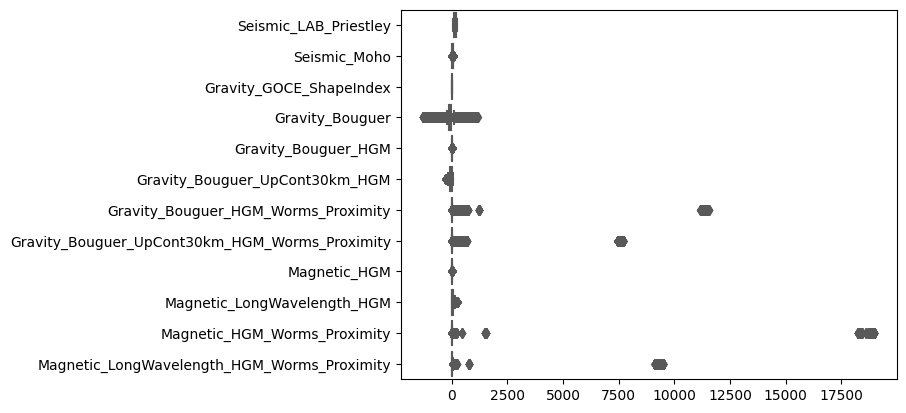

In [8]:
ax = sns.boxplot(data=mvt_data, orient="h", palette="Set2")

We can remove these outliers

In [ ]:
mvt_data = utils.tukey_remove_outliers(mvt_data)
ax = sns.boxplot(data=mvt_data, orient="h", palette="Set2")

There are also many NaNs in the data, these can be "imputed" with the mean value.

In [ ]:
print(mvt_data.isna().sum())

In [ ]:
mvt_data = utils.impute_nans(mvt_data)
print(mvt_data.isna().sum())

Finally, it can be observed the above data is not "normalized", we should make features standard scores / z-scores

In [ ]:
mvt_data = utils.normalize_df(mvt_data)
ax = sns.boxplot(data=mvt_data, orient="h", palette="Set2")
print("(note remaining outliers above were within the Tukey fences calculated over ALL the data)")

Discretizes the continuous variables in 5 bins

In [ ]:
nbins = 5
for col in baseline_cols:
    mvt_data[col] = pd.qcut(mvt_data[col], nbins)
mvt_data["target"] = mvt_labels

WOE and IV computation from online

Computes WOE / IV for each variable

In [ ]:
lst = []
IV_df = pd.DataFrame(columns=['Variable','IV'])
for col in mvt_data.columns:
    if col == 'DEFAULTER': continue
    else:
        df, iv = utils.calculate_woe_iv(mvt_data, col, 'target')
               
    lst.append(df)
    IV_df = pd.concat([IV_df, pd.DataFrame([{"Variable" :col ,"IV" : iv,}])],ignore_index=True)

Merge the WOE data into the existig input datacube

In [ ]:
# shows the overall IV for all variables on MVT deposits/occurences
print(f"Information Value Overview:\n{IV_df}\n\n\n")

# shows the WOE for all variables on MVT deposits/occurences
mvt_result = mvt_data
for i, col in enumerate(baseline_cols):
    col_data = lst[i]
    col_data = col_data.rename(columns={"Value":col,"WoE":f"{col}_WoE", "IV":f"{col}_IV"})
    mvt_result = pd.merge(mvt_result, col_data[[col,f"{col}_WoE",f"{col}_IV"]], on=col)

Combines the WOE for each comlumn

In [ ]:
mvt_result["WOE Total"] = mvt_result.loc[:,[f"{col}_WoE" for col in baseline_cols]].sum(axis=1)

Adds the latitudes to the datacube to make train, validation, and test splits

In [ ]:
mvt_result["Latitude_EPSG4326"] = data["Latitude_EPSG4326"]
te_df, tr_df, splits = utils.get_spatial_cross_val_idx(mvt_result)

In [ ]:
auc_score = roc_auc_score(tr_df["target"],tr_df["WOE Total"])
print(f"Train AUC score:{auc_score}")
auc_score = roc_auc_score(te_df["target"],te_df["WOE Total"])
print(f"Test AUC score:{auc_score}")
auc_score = roc_auc_score(mvt_result["target"],mvt_result["WOE Total"])
print(f"All AUC score:{auc_score}")

Shows the cross validation splits (train / val); test split is held out of cross validation

In [ ]:
for i, (train_index, val_index) in enumerate(splits):
    print(f"Fold {i}:")
    print(f"  Train: groups={np.unique(tr_df.iloc[train_index.tolist()]['group'].tolist())}")
    print(f"  Val: groups={np.unique(tr_df.iloc[val_index.tolist()]['group'].tolist())}")